In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from sbi.analysis import pairplot
from sbi.inference import SNPE
from sbi.utils import BoxUniform, posterior_nn
from torch import ones, zeros
import pickle

from sbi.analysis import conditional_pairplot
import pickle
import sbi
from sbi.analysis import conditional_corrcoeff
from sbi.analysis import eval_conditional_density
from helpers import *
import time
sys.path.append("../../../arco_sims/adaptive_box_posteriors/")
from  bounds import bounds_

In [3]:
xo = torch.tensor([3.1, 3.1, 3.1, 3.1, 3.1, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5])

In [4]:
filepath = "/home/michael/Documents/arco_sims/adaptive_box_posteriors2/simulations_r2/87__73418029210004229__0.005/"

In [5]:
merge_raw_pickles(filepath)

In [6]:
dataset_r2 = np.load(
    filepath+"/theta_and_x.npz",
    allow_pickle=True,
)
theta_r2 = dataset_r2["theta"].tolist()
x_r2 = dataset_r2["x"].tolist()

In [7]:
all_stats = []
for k in x_r2.keys():
    np_stat = np.asarray(x_r2[k])
    if k[:3] == "bAP" or k[:3] == "BAC":
        np_stat[np_stat < 3.1] = 3.1
    else:
        np_stat[np_stat < 4.5] = 4.5

    all_stats.append(np_stat)
all_stats_r2 = np.asarray(all_stats).T

In [8]:
min_ = torch.as_tensor(list(bounds_['87', '73418029210004229']["min"].values()), dtype=torch.float32)
max_ = torch.as_tensor(list(bounds_['87', '73418029210004229']["max"].values()), dtype=torch.float32)
value_ = torch.as_tensor(list(bounds_['87', '73418029210004229']["value"].values()), dtype=torch.float32)

In [9]:
limits = torch.stack([min_, max_]).T
prior = BoxUniform(min_, max_)

In [10]:
theta = torch.as_tensor(theta_r2, dtype=torch.float32)
x = torch.as_tensor(all_stats_r2, dtype=torch.float32)

In [11]:
density_estimator = posterior_nn("nsf", num_bins=10, num_transforms=5, hidden_features=50)

In [12]:
torch.manual_seed(0)
inference = SNPE(prior=prior, density_estimator=density_estimator)
inference = inference.append_simulations(theta, x)
density_estimator = inference.train(training_batch_size=500)

Neural network successfully converged after 81 epochs.


In [13]:
posterior = inference.build_posterior().set_default_x(xo)

In [15]:
with open("posterior_r2_87_73418_10bins_5tf_50hidden.pickle", "wb") as handle:
    pickle.dump(posterior, handle)

In [27]:
samples = posterior.sample((10_000,))

In [28]:
np.save("samples_r2_87_73418_10bins_5tf_50hidden.npy", samples.numpy())

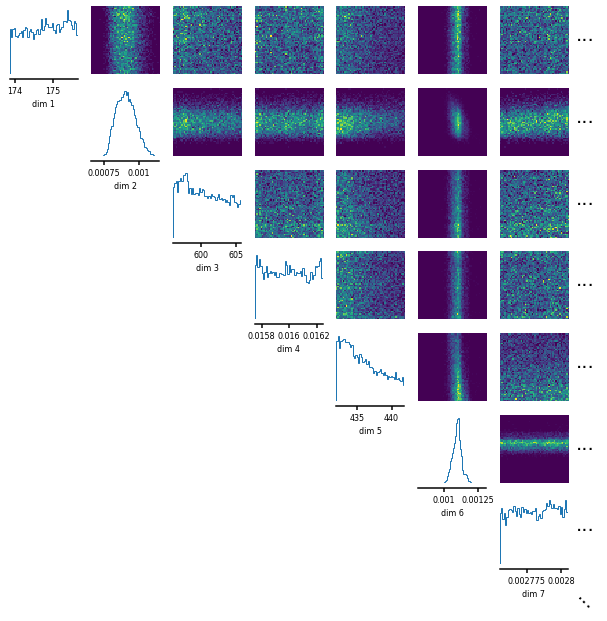

In [29]:
_ = pairplot(samples, limits=limits, subset=[0, 1, 2, 3, 4, 5, 6])

### Load posterior from r1 just to compare

In [94]:
filepath = "/home/michael/Documents/arco_sims/adaptive_box_posteriors2/87_73418029210004229_0.005.pickle"
with open(filepath, "rb") as handle:
    posterior_r1 = pickle.load(handle)

In [95]:
posterior_r1 = posterior_r1.set_default_x(xo)

In [96]:
samples_r1 = posterior_r1.sample((1000,))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


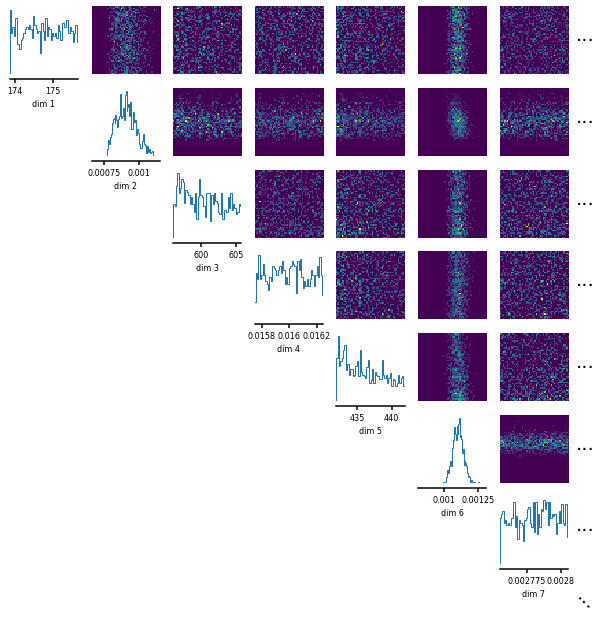

In [98]:
_ = pairplot(samples_r1, limits=limits, subset=[0, 1, 2, 3, 4, 5, 6])